In [1]:
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.plotting import plot_dataset,plot_by_id
from qcodes.logger.logger import start_all_logging
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm 
from qcodes.loops import Loop 
from matplotlib import cm
from cycler import cycler
from pprint import pprint
from time import sleep

import matplotlib.pyplot as plt
import scipy.constants as cst
import plotly.express as px
import pickle as pk
import qcodes as qc
import pandas as pd
import numpy as np
import datetime
import warnings
import time
import json
import sys
import os

In [2]:
%matplotlib widget

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sys.path.append('C:\QCodes_Driver_And_Scripts\drivers')
# sys.path.append('C:\QCodes_Driver_And_Scripts\drivers\rfsoc\RFSoC')


from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from RS_SGS_100A import SGS100A
from RS_SMB_100A import SMB100A
from RFSoC import RFSoC
    
try:
    lo_adc=SMB100A('lo_adc','TCPIP0::192.168.10.6::inst0::INSTR')

except KeyError as er:
    SMB100A.close_all()
    lo_adc=SMB100A('lo_adc','TCPIP0::192.168.10.6::inst0::INSTR')


try:
    lo_dac=SGS100A('lo_dac','TCPIP0::192.168.10.55::inst0::INSTR')

except KeyError as er:
    SGS100A.close_all()
    lo_dac=SGS100A('lo_dac','TCPIP0::192.168.10.55::inst0::INSTR')
    
# try:
#     seed_source=SGS100A('lo_dac','TCPIP0::192.168.10.56::inst0::INSTR')

# except KeyError as er:
#     SGS100A.close_all()
#     seed_source=SGS100A('lo_dac','TCPIP0::192.168.10.56::inst0::INSTR')
    
try:
    rfsoc = RFSoC('RFSoC', 'TCPIP::{}::{}::SOCKET'.format('192.168.10.123',5001))
except KeyError as er:
    rfsoc.close_all()
    
try:
    I_source = GS200("gs200", address='TCPIP::192.168.10.3::INSTR', terminator="\n")
except KeyError as er:
    GS200.close_all() #Disconnect and irreversibly tear down the instrument
    I_source = GS200("gs200", address='TCPIP::192.168.10.3::INSTR', terminator="\n")



Connected to: Rohde&Schwarz SMB100A (serial:1406.6000k03/177959, firmware:3.1.18.2-3.01.203.32) in 0.06s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/114047, firmware:4.2.76.0-4.30.046.295) in 0.02s
Connected to: YOKOGAWA GS210 (serial:90Y438440, firmware:2.02) in 0.02s


In [5]:
rfsoc.compute_full_sequence = False
rfsoc.debug_mode = True
rfsoc.debug_mode_plot_waveforms = True
rfsoc.display_IQ_progress = False 
# rfsoc.DAC_amplitude_calib = [1.02233566,1.02233566,1.02233566,1.02233566,1.02233566,1.02233566,1.02233566,1.02233566]

In [6]:
# rfsoc.reset_PLL()

In [7]:
def powtov(power) :
    poww = 10**(power/10)/1000
    v = np.sqrt(50*poww*2)
    return v
def vtopow(v) :
    poww = v**2/(100)
    power = 10*np.log10(poww/0.001)
    return power
def vtopowlin(v) :
    poww = v**2/(100)
    return poww

In [8]:

def measure(lo_dac_freq,adc_amp, exp, station):
  
    meas = qc.Measurement(exp=exp, station=station)
    meas.register_parameter(lo_dac.frequency)
    meas.register_parameter(lo_adc.freq_vec)
    meas.register_custom_parameter(name='spectrum_mw_on',paramtype='array',setpoints=[lo_dac.frequency])
    meas.register_custom_parameter(name='spectrum_mw_off',paramtype='array',setpoints=[lo_dac.frequency])

    # meas.write_period = 10

    with meas.run() as datasaver:
    
        id=datasaver.dataset.run_id
        qc.load_by_run_spec( captured_run_id=id).add_metadata('parameter_snap',
                             json.dumps(parameter_snap))

        for f in tqdm(lo_dac_freq):
            
            lo_dac.frequency(f*1.e6)
            
            get_s_off  = np.zeros(int(lo_adc.freq_points())-1)
            get_s      = np.zeros(int(lo_adc.freq_points())-1)
            
            # print(len(get_s))
            
            for n in tqdm(range(trace_average),leave=False):
                
                lo_adc.restartsweep()

                res=rfsoc.IQINT_ALL.get()
                I_no_avg = res[0][channel_ro-1].reshape(rfsoc.n_points(), 2*average)[:,2:] #we trash the first average point 
                Q_no_avg = res[1][channel_ro-1].reshape(rfsoc.n_points(), 2*average)[:,2:] #we trash the first average point 

                # print(I_no_avg[:,::2].shape)
                # print(I_no_avg.shape)

                I_no_avg_on  = I_no_avg[:,::2]
                I_no_avg_off = I_no_avg[:,1::2]

                Q_no_avg_on  = Q_no_avg[:,::2]
                Q_no_avg_off = Q_no_avg[:,1::2]
                
                P_off = (1/adc_amp*2)**2*np.average(I_no_avg_off**2+Q_no_avg_off**2,axis=1) / 2 / 50
                P_on = (1/adc_amp*2)**2*np.average(I_no_avg_on**2+Q_no_avg_on**2,axis=1) / 2 / 50

                # print(len(P_off))
                # print(len(P_on))
                get_s_off  += P_off
                get_s      += P_on

            datasaver.add_result(('spectrum_mw_on', get_s/trace_average),('spectrum_mw_off',get_s_off/trace_average),(lo_dac.frequency,float(lo_dac.frequency())),
                                 (lo_adc.freq_vec,lo_adc.freq_vec()))

In [9]:
a = np.zeros(10)
b=np.random.normal(0,10,10)

In [10]:
start_all_logging()

# Create a station
station = qc.Station()
station.add_component(rfsoc)
station.add_component(lo_adc)
station.add_component(lo_dac)
station.add_component(I_source)

station.snapshot()
station.components

# Experiment details
date=datetime.datetime.today().strftime('%Y_%m_%d')
user='DF'
description='rfsoc_fluorescence'
database_name = date+"_"+user+"_"+description

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.ROCH\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.ROCH\.qcodes\logs\221104-2672-qcodes.log


2022-11-04 15:14:28,147 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 269 ¦ [gs200_program(GS200Program)] Snapshot: Could not update parameter: trigger


In [11]:
script_dir=os.path.dirname(os.path.abspath("__file__"))
data_dir=os.path.join('C:\\QCodes_Driver_And_Scripts\\Data_QCodes\\Dorian\\'+date)

try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

data_dir=data_dir +'\\'+description

try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

In [12]:
qc.initialise_or_create_database_at(data_dir+'\\'+database_name+'.db')
qc.config.core.db_location

parameter_snap={}

In [13]:
current = -14.856#mA
# current = 0 #mA


# Snapshot parameters
parameter_snap['flux']={'current': current}

In [14]:
#rfsoc dac parameters
amp_sig   = powtov(0)
print(amp_sig)
freq_if   = 100                #MHz
dc_off    = 0
phase_if  = 0
phase_off = 258.6842 #deg

# parameter_snap['rfsoc']={'amp_sig':amp_sig,'freq_if':freq_if,'dc_off':dc_off,'phase_if':phase_if,'phase_off':phase_off}

#input tone 
freq_in_center = 2902 #MHz
freq_in_span   = 400  #MHz
freq_in_points = 50
freq_in_points = 1
freq_in_vec    = np.linspace(freq_in_center-0.5*freq_in_span,freq_in_center + 0.5*freq_in_span,freq_in_points)
freq_in_vec    = np.array([freq_in_center])
#lo dac parameters
lo_dac_vec   = freq_in_vec - freq_if #USB
lo_dac_power = 15 + 1.5          #adding the cable att 

parameter_snap['lo_dac']={'center':freq_in_center - freq_if, 'span':freq_in_span,'points':freq_in_points,'power':lo_dac_power}

#output probe
freq_out_center = 8460 #MHz
freq_out_span   = 200#MHz
# freq_out_points = 200
freq_out_points = 100
freq_out_vec    = np.linspace(freq_out_center-0.5*freq_out_span,freq_out_center + 0.5*freq_out_span,freq_out_points)
#lo adc parameters
lo_adc_vec    = freq_out_vec + freq_if # f_if = |f_lo - f_rf| 
lo_adc_power  = 20.5 + 1.5
lo_adc_points = len(lo_adc_vec)
parameter_snap['lo_adc']={'center':freq_out_center + freq_if, 'span':freq_out_span,'points':freq_out_points,'power':lo_adc_power}

0.31622776601683794


In [15]:
#pulse sequence definition
#trigger 
time_start_trigger = rfsoc.time_conversion(0)
trigger_length     = rfsoc.time_conversion(1) 
wait_after_trig    = rfsoc.time_conversion(10e3)
#generation
time_start_dac     = wait_after_trig + trigger_length
#acquisition
time_shift         = rfsoc.time_conversion(.5)
time_start_adc     = time_start_dac + time_shift
acq_length         = rfsoc.time_conversion(0.1)
dead_time          = rfsoc.time_conversion(4.)

#number of averages
average = 500
trace_average  = 1

parameter_snap['pulse_seq']={'time_start_trig':time_start_trigger,'trigger_length':trigger_length,'time_start_dac':time_start_dac,'time_shift':time_shift,
                             'time_start_adc':time_start_adc,'acq_length':acq_length,'dead_time':dead_time,'average':average,'trace_average':trace_average}

In [16]:
2_500_000 / 50_000

50.0

In [17]:
channel_ro = 2 
channel_demod = [2]

In [18]:
#rfsoc mix ADC
param_sin_1 = {'amp':1.0,
               'freq':freq_if,
               'dc_offset':0,
               'phase_offset':0*np.pi/180}
#rfsoc IQ DAC
param_sin_I = {'amp':amp_sig,
               'freq':freq_if,
               'dc_offset':0.02653,
               'phase_offset':0}

param_sin_Q = {'amp':amp_sig*0.9417,
               'freq':freq_if,
               'dc_offset':0.01447,
               'phase_offset':phase_off*np.pi/180}

param_sin_I_off = {'amp':0,
               'freq':freq_if,
                'dc_offset':0.02653,
               'phase_offset':0}

param_sin_Q_off = {'amp':0,
               'freq':freq_if,
              'dc_offset':0.01447,
               'phase_offset':phase_off*np.pi/180}

pulse_sin_I = dict(label='signal_I', 
                      module='DAC', 
                      channel=1, 
                      mode='sin', 
                      start=time_start_dac, 
                      length=acq_length+2*time_shift,
                      dead_time = acq_length +2*dead_time + 2*time_shift,
                      repetitions=average,
                      param=param_sin_I, 
                      LUT=True,
                      starting_pointer=0,
                      parent=None)

pulse_sin_Q = dict(label='signal_Q', 
                      module='DAC', 
                      channel=2, 
                      mode='sin', 
                      start=time_start_dac, 
                      length=acq_length+2*time_shift,
                      dead_time = acq_length +2*dead_time + 2*time_shift,
                      repetitions=average,
                      param=param_sin_Q, 
                      LUT=True,
                      starting_pointer=0,
                      parent=None)

pulse_sin_I_off = dict(label='signal_I_off', 
                      module='DAC', 
                      channel=1, 
                      mode='sin', 
                      start=pulse_sin_I['start'] + pulse_sin_I['length']+dead_time, 
                      length=acq_length+2*time_shift,
                      dead_time = dead_time,
                      repetitions=average,
                      param=param_sin_I_off, 
                      LUT=True,
                      starting_pointer=0,
                      parent=None)

pulse_sin_Q_off = dict(label='signal_Q_off', 
                      module='DAC', 
                      channel=2, 
                      mode='sin', 
                      start=pulse_sin_Q['start'] + pulse_sin_Q['length']+dead_time, 
                      length=acq_length+2*time_shift,
                      dead_time = dead_time,
                      repetitions=average,
                      param=param_sin_Q_off, 
                      LUT=True,
                      starting_pointer=0,
                      parent=None)

# pulse_wait = dict(label='wait_after_trigger',
#                       module='DAC', 
#                       channel=1, 
#                       mode='DC',
#                       start=time_start_trigger + trigger_length,
#                       length = time_start_dac - (time_start_trigger + trigger_length),
#                       repetitions=1, 
#                       param={'amp':0},
#                       LUT=True,
#                       parent=None)

record_sin_on = dict(label='record_signal_on', 
                      module='ADC', 
                      channel=channel_ro,
                      LUT = True,
                      demodulation_channels=channel_demod,
                      mode='sin', 
                      start=time_start_adc, 
                      length=acq_length, 
                      dead_time = pulse_sin_I['length']+2*(dead_time)+2*time_shift,
                      repetitions=average,
                      param=[param_sin_1], 
                      parent=None)

record_sin_off = dict(label='record_signal_off', 
                      module='ADC', 
                      channel=channel_ro,
                      LUT = True,
                      mode='sin', 
                      demodulation_channels=channel_demod,
                      start=pulse_sin_I['start'] + pulse_sin_I['length'] + dead_time + time_shift, 
                      length=acq_length, 
                      dead_time = dead_time,
                      repetitions=average,
                      param=[param_sin_1], 
                      parent=None)

trigger_pulse = dict(label='trigger', 
                     module='DAC', 
                     channel=1, 
                     mode='trigger', 
                     start =time_start_trigger, 
                     length=trigger_length, 
                     repetitions=1,
                     LUT=True,
                     starting_pointer=0,
                     param=None, 
                     parent=None)
                     
parameter_snap['RfSoc'] = {'amp_sig' : amp_sig, 'freq_sig': freq_if, 
                          'phase_sig': phase_if, 'offset' : [dc_off,phase_off],
                          'start_sig': time_start_adc, 'sig_length' : acq_length,
                          'record_start': time_start_dac}
pulses = pd.DataFrame()
pulses = pd.concat([pulses, pd.DataFrame.from_records([trigger_pulse])], ignore_index=True)
# pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_wait])], ignore_index=True)  
pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_sin_I])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_sin_Q])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_sin_I_off])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_sin_Q_off])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([record_sin_on])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([record_sin_off])], ignore_index=True)

rfsoc.pulses = pulses

Hierarchy resolution...


module  channel     mode    start  length  repetitions  \
label                                                                      
trigger              DAC        1  trigger      0.0     1.0            1   
signal_I             DAC        1      sin  10001.0     1.1          500   
signal_Q             DAC        2      sin  10001.0     1.1          500   
signal_I_off         DAC        1      sin  10006.1     1.1          500   
signal_Q_off         DAC        2      sin  10006.1     1.1          500   
record_signal_on     ADC        2      sin  10001.5     0.1          500   
record_signal_off    ADC        2      sin  10006.6     0.1          500   

                    LUT  starting_pointer  \
label                                       
trigger            True               0.0   
signal_I           True               0.0   
signal_Q           True               0.0   
signal_I_off       True               0.0   
signal_Q_off       True               0.0   
record_signal_on   True               NaN   
record_signal_off  True               NaN   

                                                               param parent  \
label                                                                         
trigger                                                         None   None   
signal_I           {'amp': 0.31622776601683794, 'freq': 100, 'dc_...   None   
signal_Q           {'amp': 0.29779168725805627, 'freq': 100, 'dc_...   None   
signal_I_off       {'amp': 0, 'freq': 100, 'dc_offset': 0.02653, ...   None   
signal_Q_off       {'amp': 0, 'freq': 100, 'dc_offset': 0.01447, ...   None   
record_signal_on   [{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'ph...   None   
record_signal_off  [{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'ph...   None   

                   dead_time demodulation_channels  
label                                               
trigger                  NaN                   NaN  
signal_I                 9.1                   NaN  
signal_Q                 9.1                   NaN  
signal_I_off             4.0                   NaN  
signal_Q_off             4.0                   NaN  
record_signal_on        10.1                   [2]  
record_signal_off        4.0                   [2]

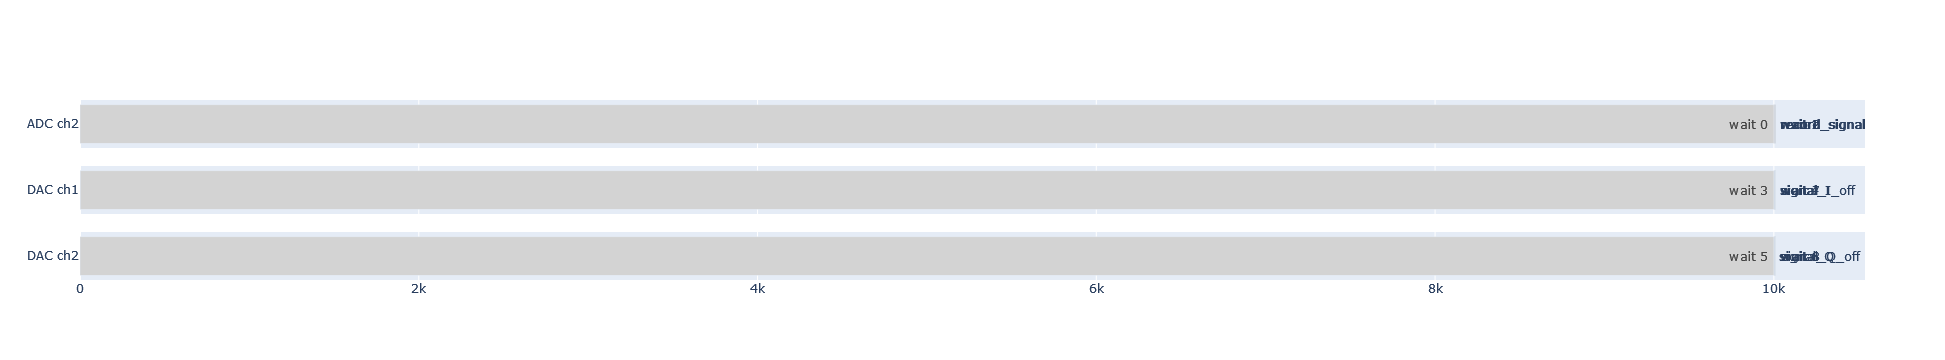

2022-11-04 15:14:28,738 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------------------------------- LUT DEBUGGING DAC ----------------------------------
For pulse trigger
Saved pointer: 0
For pulse signal_I
Saved pointer: 251
plot of sin mode


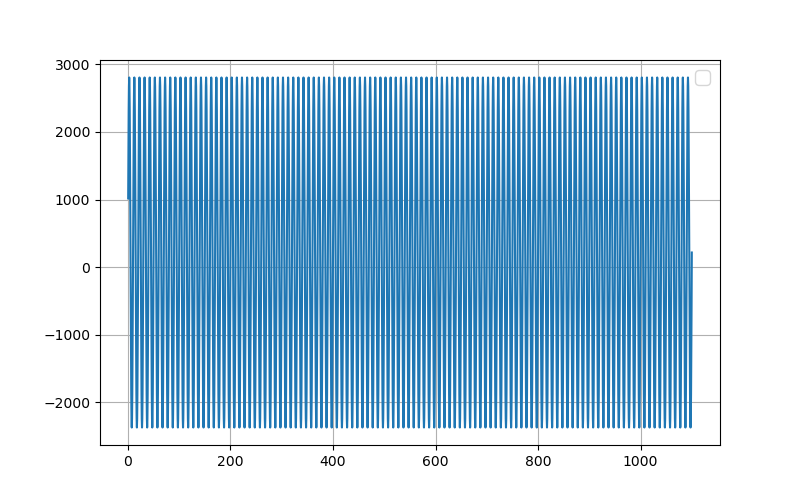

2022-11-04 15:14:28,868 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


For pulse signal_Q
Saved pointer: 0
plot of sin mode


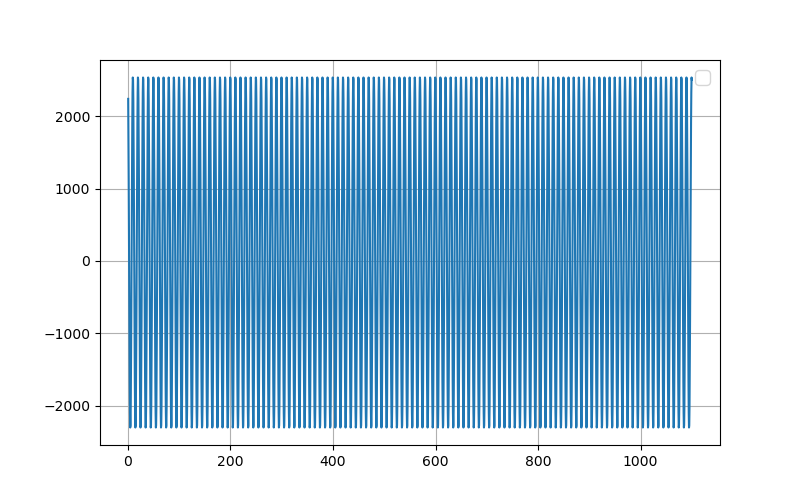

2022-11-04 15:14:28,974 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


For pulse signal_I_off
Saved pointer: 527
plot of sin mode


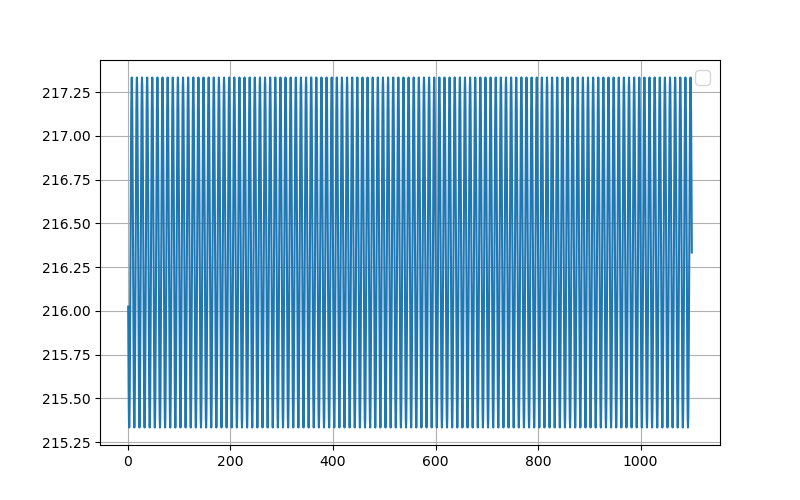

2022-11-04 15:14:29,083 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


For pulse signal_Q_off
Saved pointer: 276
plot of sin mode


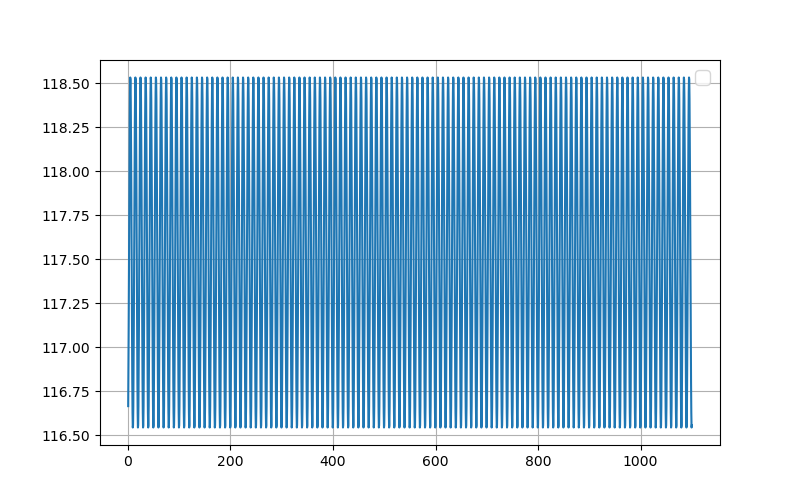

2022-11-04 15:14:29,194 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pointer tab:
[[0, 251, 527], [0, 276], [], [], [], [], [], []]


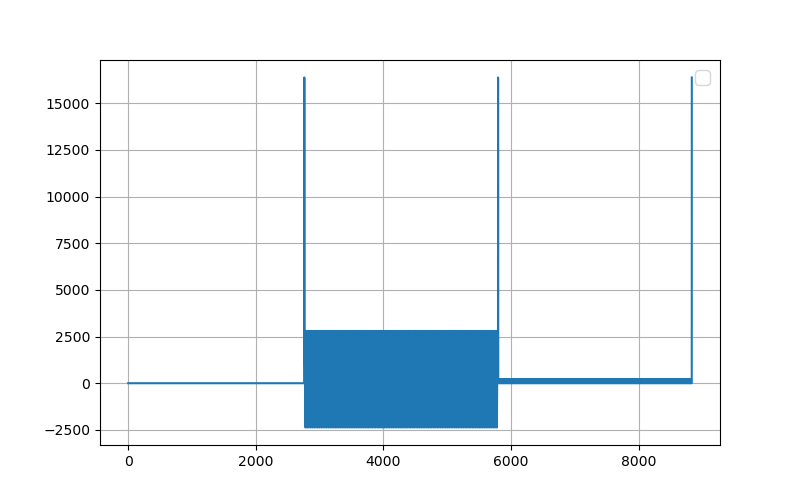

2022-11-04 15:14:29,272 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


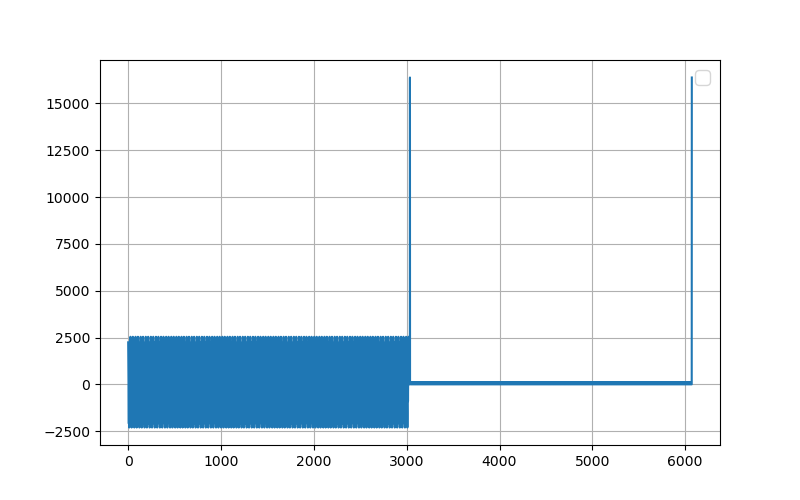

------------------------------- LUT DEBUGGING ADC ----------------------------------


label    start     stop     time module  Channel  mode  \
0             wait 0      0.0  10001.5  10001.5    ADC  ADC ch2  wait   
1   record_signal_on  10001.5  10001.6      0.1    ADC  ADC ch2   sin   
2             wait 1  10001.6  10006.6      5.0    ADC  ADC ch2  wait   
3  record_signal_off  10006.6  10006.7      0.1    ADC  ADC ch2   sin   
4             wait 2  10006.7  10010.7      4.0    ADC  ADC ch2  wait   

     color                                              param  ch_num  rep_nb  \
0  #D3D3D3                                               None       2       1   
1  #913608  [{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'ph...       2     500   
2  #808080                                               None       2     500   
3  #913608  [{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'ph...       2     500   
4  #808080                                               None       2     500   

     LUT ch_demod  start_pointer  
0  False      [2]            NaN  
1   True      [2]            0.0  
2  False      [2]            NaN  
3   True      [2]            0.0  
4  False      [2]            NaN

Pulse not found in ADC memory
Starting pointer set at: 0
The pulses saved in the LUT are:
sin True record_signal_on
[{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'phase_offset': 0.0}]
Demodulation period/ Loop period/ Time vec: 
10 4 0.02
plot of sin mode


2022-11-04 15:14:29,367 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


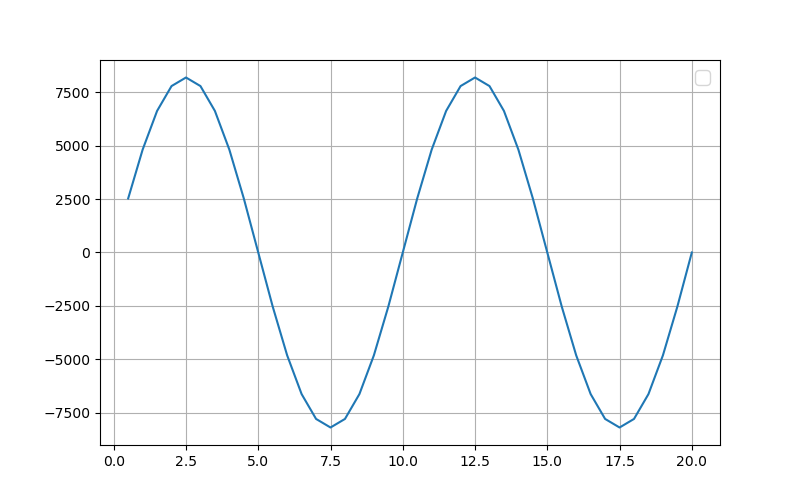

2022-11-04 15:14:29,443 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot of sin mode


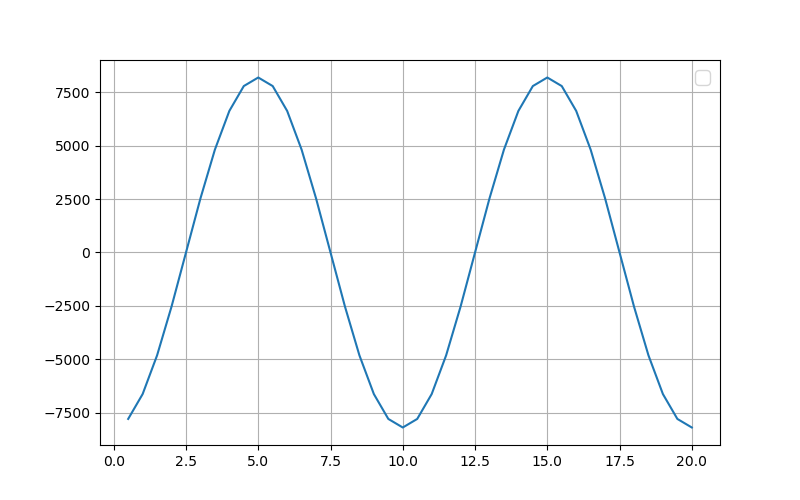

[ 2.53015820e+03  4.81354900e+03  6.62565820e+03  7.78910392e+03
  8.19000000e+03  7.78910392e+03  6.62565820e+03  4.81354900e+03
  2.53015820e+03 -1.00000000e+00 -2.53215820e+03 -4.81554900e+03
 -6.62765820e+03 -7.79110392e+03 -8.19200000e+03 -7.79110392e+03
 -6.62765820e+03 -4.81554900e+03 -2.53215820e+03 -1.00000000e+00
  2.53015820e+03  4.81354900e+03  6.62565820e+03  7.78910392e+03
  8.19000000e+03  7.78910392e+03  6.62565820e+03  4.81354900e+03
  2.53015820e+03 -1.00000000e+00 -2.53215820e+03 -4.81554900e+03
 -6.62765820e+03 -7.79110392e+03 -8.19200000e+03 -7.79110392e+03
 -6.62765820e+03 -4.81554900e+03 -2.53215820e+03 -1.00000000e+00]
For pulse record_signal_on
Saved start/loop/stop pointer:  0 0 4
Pulse not found in ADC memory
Starting pointer set at: 5
The pulses saved in the LUT are:
sin True record_signal_off
[{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'phase_offset': 0.0}]
Demodulation period/ Loop period/ Time vec: 
10 4 0.02
plot of sin mode


2022-11-04 15:14:29,520 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


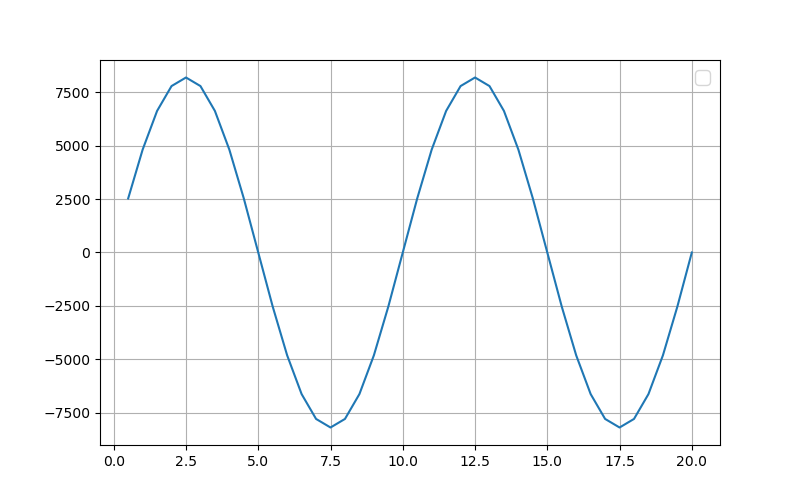

2022-11-04 15:14:29,598 ¦ matplotlib.legend ¦ WARNING ¦ legend ¦ _parse_legend_args ¦ 1236 ¦ No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot of sin mode


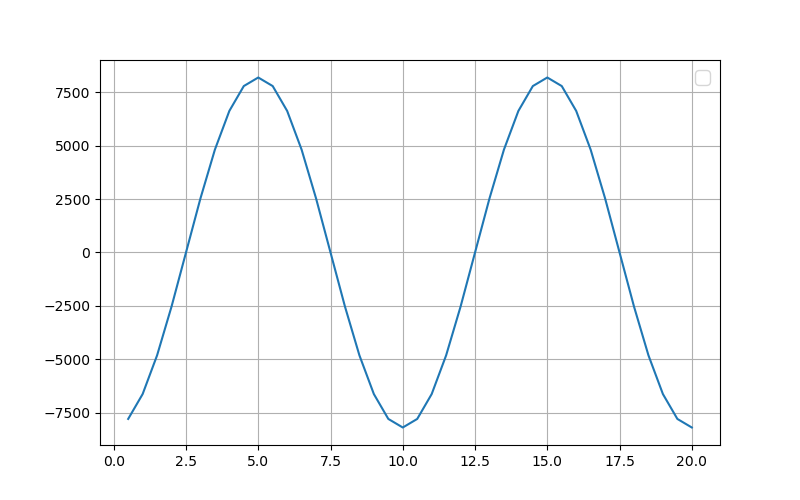

[ 2.53015820e+03  4.81354900e+03  6.62565820e+03  7.78910392e+03
  8.19000000e+03  7.78910392e+03  6.62565820e+03  4.81354900e+03
  2.53015820e+03 -1.00000000e+00 -2.53215820e+03 -4.81554900e+03
 -6.62765820e+03 -7.79110392e+03 -8.19200000e+03 -7.79110392e+03
 -6.62765820e+03 -4.81554900e+03 -2.53215820e+03 -1.00000000e+00
  2.53015820e+03  4.81354900e+03  6.62565820e+03  7.78910392e+03
  8.19000000e+03  7.78910392e+03  6.62565820e+03  4.81354900e+03
  2.53015820e+03 -1.00000000e+00 -2.53215820e+03 -4.81554900e+03
 -6.62765820e+03 -7.79110392e+03 -8.19200000e+03 -7.79110392e+03
 -6.62765820e+03 -4.81554900e+03 -2.53215820e+03 -1.00000000e+00]
For pulse record_signal_off
Saved start/loop/stop pointer:  5 5 9
Pointer tab:
[[[], [], []], [[0, 5], [0, 5], [4, 9]], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []]]


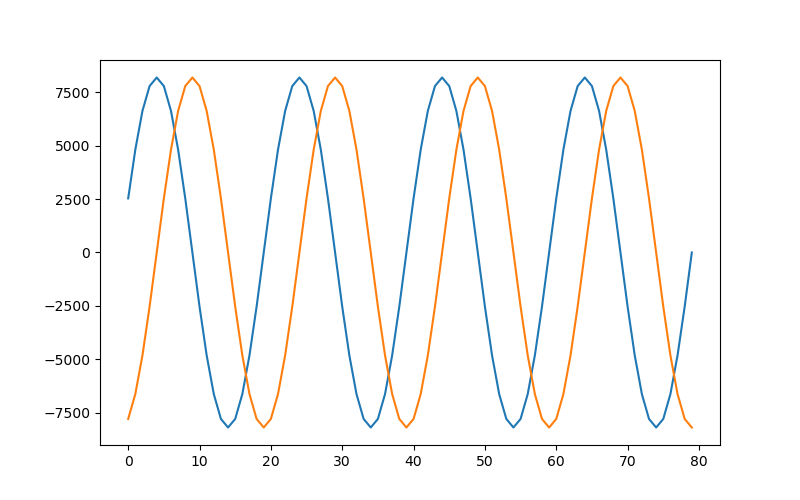

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
*-*-*-*-*-*-*-* Beggining of sequence *-*-*-*-*-*-*-*-*-*-*
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Events detected at:  [0.0, 1.0, 10001.0, 10001.5, 10001.6, 10002.1, 10006.1, 10006.6, 10006.7, 10007.2]
Found the following pulses:


label    start     stop     time module  Channel     mode  \
0              wait 0      0.0  10001.5  10001.5    ADC  ADC ch2     wait   
5             trigger      0.0      1.0      1.0    DAC  DAC ch1  trigger   
11             wait 5      0.0  10001.0  10001.0    DAC  DAC ch2     wait   
6              wait 3      1.0  10001.0  10000.0    DAC  DAC ch1     wait   
7            signal_I  10001.0  10002.1      1.1    DAC  DAC ch1      sin   
12           signal_Q  10001.0  10002.1      1.1    DAC  DAC ch2      sin   
1    record_signal_on  10001.5  10001.6      0.1    ADC  ADC ch2      sin   
2              wait 1  10001.6  10006.6      5.0    ADC  ADC ch2     wait   
8              wait 4  10002.1  10006.1      4.0    DAC  DAC ch1     wait   
13             wait 6  10002.1  10006.1      4.0    DAC  DAC ch2     wait   
9        signal_I_off  10006.1  10007.2      1.1    DAC  DAC ch1      sin   
14       signal_Q_off  10006.1  10007.2      1.1    DAC  DAC ch2      sin   
3   record_signal_off  10006.6  10006.7      0.1    ADC  ADC ch2      sin   
4              wait 2  10006.7  10010.7      4.0    ADC  ADC ch2     wait   
10             wait 7  10007.2  10011.2      4.0    DAC  DAC ch1     wait   
15             wait 8  10007.2  10011.2      4.0    DAC  DAC ch2     wait   

      color                                              param  ch_num  \
0   #D3D3D3                                               None       2   
5   #306CC7                                               None       1   
11  #D3D3D3                                               None       2   
6   #D3D3D3                                               None       1   
7   #234E90  {'amp': 0.31622776601683794, 'freq': 100, 'dc_...       1   
12  #234E90  {'amp': 0.29779168725805627, 'freq': 100, 'dc_...       2   
1   #913608  [{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'ph...       2   
2   #808080                                               None       2   
8   #808080                                               None       1   
13  #808080                                               None       2   
9   #234E90  {'amp': 0, 'freq': 100, 'dc_offset': 0.02653, ...       1   
14  #234E90  {'amp': 0, 'freq': 100, 'dc_offset': 0.01447, ...       2   
3   #913608  [{'amp': 1.0, 'freq': 100, 'dc_offset': 0, 'ph...       2   
4   #808080                                               None       2   
10  #808080                                               None       1   
15  #808080                                               None       2   

    rep_nb    LUT ch_demod  start_pointer  
0        1  False      [2]            NaN  
5        1   True      NaN            0.0  
11       1  False      NaN            NaN  
6        1  False      NaN            NaN  
7      500   True      NaN            0.0  
12     500   True      NaN            0.0  
1      500   True      [2]            0.0  
2      500  False      [2]            NaN  
8      500  False      NaN            NaN  
13     500  False      NaN            NaN  
9      500   True      NaN            0.0  
14     500   True      NaN            0.0  
3      500   True      [2]            0.0  
4      500  False      [2]            NaN  
10     500  False      NaN            NaN  
15     500  False      NaN            NaN

They will all be played a first time and then the pulses with rep_nb=500 will be played 500 times
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
0.0 trigger trigger
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
adding sequencer command to point to address of this pulse
4097 0
DAC state is : [0, 0, 0, 0, 0, 0, 0, 1]
Pointer shifted to 1
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
0.0 wait wait 5
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
DAC state is : [0, 0, 0, 0, 0, 0, 0, 1]
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
0.0 wait wait 0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
wait
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
ADC state is : [0, 0, 0, 0, 0, 0, 0, 0]
ADC state updated from [0, 0, 0, 0, 0, 0, 0, 0] to [0, 0, 0, 0, 0, 0, 0, 0]
DAC state updated from [0, 0, 0, 0, 0, 0, 0, 0] to [0, 0, 0, 0, 0, 0, 0, 1]
Bit string of the DAC state:
000000000000000000000011
Bit string of the ADC state
00000000
The command is: 
4096 3
adding wait till this event
1 250
_ _ 

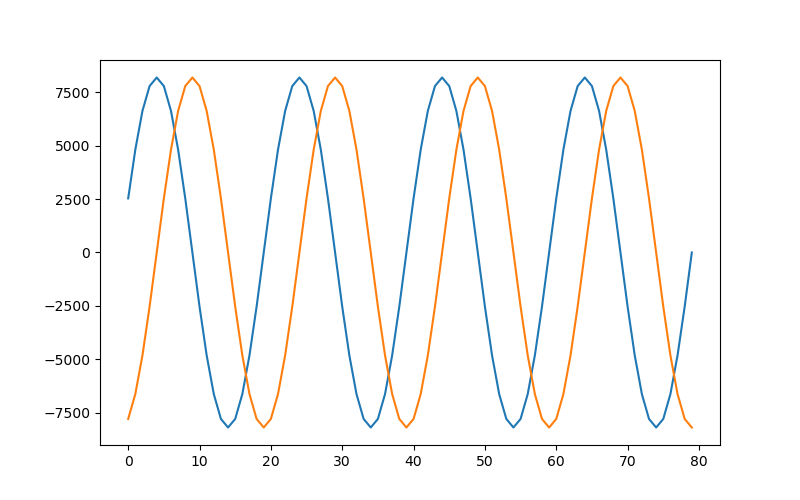

In [19]:
# rfsoc.stop_play()
rfsoc.acquisition_mode('INT')
# rfsoc.ADC1.fmixer(0)
# rfsoc.freq_sync(10e6)
# rfsoc.ADC1.status('ON')
# rfsoc.output_format('BIN')
rfsoc.n_points(freq_out_points)
rfsoc.process_sequencing_IQ_table()

In [20]:
#set up sources 
# dac source 
lo_dac.frequency(lo_dac_vec[0]*1.e6)
lo_dac.power(lo_dac_power)

#adc source
lo_adc.freq_points(len(lo_adc_vec))
lo_adc.set_gui_update('off')
lo_adc.power(lo_adc_power)
lo_adc.sourcemode('sweep')
lo_adc.sweepmode('STEP')
lo_adc.trigger_mode('EXT')
lo_adc.spacing_freq('LIN')

freq_step = lo_adc_vec[1]-lo_adc_vec[0]
print(freq_step)

lo_adc.freq_start((lo_adc_vec[0]-freq_step)*1e6) # Hack to take into account that the first frequency point of MW_source doesn't send a trigger to the VNA
lo_adc.freq_stop(lo_adc_vec[-1]*1e6)
lo_adc.freq_step(freq_step*1e6)
lo_adc.freq_points(len(lo_adc_vec)+1)
lo_adc.restartsweep()
print(lo_adc.freq_step()*1.e-6)
lo_dac.status('on')
lo_adc.status('on')

2022-11-04 15:14:29,865 ¦ RS_SMB_100A ¦ WARNING ¦ RS_SMB_100A ¦ warn_over_range ¦ 198 ¦ Power over range (limit to 16 dBm).


2.0202020202013955
2.020202021


In [21]:
len(lo_adc_vec)

100

In [22]:
if I_source.output()=='on':
    I_source.output('off')

I_source.source_mode('CURR')
I_source.range(100e-3)
  
I_source.current(current*1.e-3)

I_source.output('on')


In [23]:
# Load experiment
exp_name = 'rfsoc_fluorescence'

sample_name = 'B5_G3_GALV_SQ200_1ST'

exp=qc.load_or_create_experiment(experiment_name=exp_name,sample_name=sample_name)

measure(lo_dac_freq=lo_dac_vec,adc_amp=param_sin_1['amp'], exp=exp, station=station)

# Shutdown devices
lo_adc.status('off')
lo_dac.status('off')
I_source.reset()
rfsoc.stop_play()


Starting experimental run with id: 48. 


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
lo_adc.status('off')
lo_dac.status('off')
I_source.reset()

In [25]:
trace_avg_vec = np.unique(np.logspace(0,3,15,dtype=int))[11:]

In [26]:
trace_avg_vec

array([ 372,  610, 1000])

In [27]:
# for avg in trace_avg_vec : 
    
#     trace_average = avg
#     #set up sources 
#     # dac source 
#     lo_dac.frequency(lo_dac_vec[0]*1.e6)
#     lo_dac.power(lo_dac_power)

#     #adc source
#     lo_adc.freq_points(len(lo_adc_vec))
#     lo_adc.set_gui_update('off')
#     lo_adc.power(lo_adc_power)
#     lo_adc.sourcemode('sweep')
#     lo_adc.sweepmode('STEP')
#     lo_adc.trigger_mode('EXT')
#     lo_adc.spacing_freq('LIN')

#     freq_step = lo_adc_vec[1]-lo_adc_vec[0]
#     print(freq_step)

#     lo_adc.freq_start((lo_adc_vec[0]-freq_step)*1e6) # Hack to take into account that the first frequency point of MW_source doesn't send a trigger to the VNA
#     lo_adc.freq_stop(lo_adc_vec[-1]*1e6)
#     lo_adc.freq_step(freq_step*1e6)
#     lo_adc.freq_points(len(lo_adc_vec)+1)
#     lo_adc.restartsweep()
#     print(lo_adc.freq_step()*1.e-6)
#     lo_dac.status('on')
#     lo_adc.status('on')

#     len(lo_adc_vec)

#     if I_source.output()=='on':
#         I_source.output('off')

#     I_source.source_mode('CURR')
#     I_source.range(100e-3)

#     I_source.current(current*1.e-3)

#     I_source.output('on')


#     # Load experiment
#     exp_name = 'rfsoc_fluorescence'

#     sample_name = 'B5_G3_GALV_SQ200_1ST'

#     exp=qc.load_or_create_experiment(experiment_name=exp_name,sample_name=sample_name)

#     measure(lo_dac_freq=lo_dac_vec,adc_amp=param_sin_1['amp'], exp=exp, station=station)

#     # Shutdown devices
#     lo_adc.status('off')
#     lo_dac.status('off')
#     I_source.reset()
#     rfsoc.stop_play()


In [28]:
trace_avg_vec = np.unique(np.logspace(3,4,4,dtype=int))

In [29]:
trace_avg_vec

array([ 1000,  2154,  4641, 10000])

In [30]:
# for avg in trace_avg_vec : 
    
#     trace_average = avg
#     #set up sources 
#     # dac source 
#     lo_dac.frequency(lo_dac_vec[0]*1.e6)
#     lo_dac.power(lo_dac_power)

#     #adc source
#     lo_adc.freq_points(len(lo_adc_vec))
#     lo_adc.set_gui_update('off')
#     lo_adc.power(lo_adc_power)
#     lo_adc.sourcemode('sweep')
#     lo_adc.sweepmode('STEP')
#     lo_adc.trigger_mode('EXT')
#     lo_adc.spacing_freq('LIN')

#     freq_step = lo_adc_vec[1]-lo_adc_vec[0]
#     print(freq_step)

#     lo_adc.freq_start((lo_adc_vec[0]-freq_step)*1e6) # Hack to take into account that the first frequency point of MW_source doesn't send a trigger to the VNA
#     lo_adc.freq_stop(lo_adc_vec[-1]*1e6)
#     lo_adc.freq_step(freq_step*1e6)
#     lo_adc.freq_points(len(lo_adc_vec)+1)
#     lo_adc.restartsweep()
#     print(lo_adc.freq_step()*1.e-6)
#     lo_dac.status('on')
#     lo_adc.status('on')

#     len(lo_adc_vec)

#     if I_source.output()=='on':
#         I_source.output('off')

#     I_source.source_mode('CURR')
#     I_source.range(100e-3)

#     I_source.current(current*1.e-3)

#     I_source.output('on')


#     # Load experiment
#     exp_name = 'rfsoc_fluorescence'

#     sample_name = 'B5_G3_GALV_SQ200_1ST'

#     exp=qc.load_or_create_experiment(experiment_name=exp_name,sample_name=sample_name)

#     measure(lo_dac_freq=lo_dac_vec,adc_amp=param_sin_1['amp'], exp=exp, station=station)

#     # Shutdown devices
#     lo_adc.status('off')
#     lo_dac.status('off')
#     I_source.reset()
#     rfsoc.stop_play()
